In [ ]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

## Functions

In [ ]:
# TM10007 Machine Learning - Functions

# Importing modules
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA


def clean_data(train_data, data):
    '''
    Remove strings from data, remove features with a lot of missing values,
    and compute values to fill features with few missing values

    train_data: original (uncleaned) training dataset
    data: dataset that is cleaned (can be either train or test)
    '''

    # Replace strings with NaNs
    # Convert to numerical and make all non-numerical or inf terms NaN

    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        index = 0
        for value in data[col]:
            if np.isinf(value):
                data[col].iloc[index] = np.nan
            index += 1

    # Find missing number of values per column in training set
    missing = train_data.isnull().sum()
    col = []

    # Find columns with more missing values than 25% of the column length
    for index, value in enumerate(missing.values):
        if value > 0.25*len(train_data.index):
            col.append(index)

    # Create new dataframe without columns with more missing values than threshold
    col_name = []

    for i in col:
        col_name.append(train_data.columns[i])

    data_cleaned = data.drop(columns=col_name)

    return data_cleaned


def scale_data(train_data, data):
    '''
    Scaling the data using a Robust Scaler with a specified quantile range

    train_data: training dataset used to fit the scaler
    data: dataset that will be scaled (can be either train or test set)
    '''

    # Use Robust Scalar with specified quantile range
    scaler = RobustScaler(quantile_range=(15.0, 85.0))

    # Fit scaler to training dataset
    scaler.fit(train_data)

    # Use scaler to transform dataset (train or test)
    data_scaled = scaler.transform(data)

    # Specify a min and max value after scaling (-4 and 4)
    data_scaled[data_scaled < -4] = -4
    data_scaled[data_scaled > 4] = 4

    return data_scaled


def imputation(train_data, data_scaled):
    '''
    Applying a kNN imputation method to complete missing values in the data

    train_data: scaled training dataset to fit the imputer (can be either train or test set)
    data_scaled: dataset that will be filled
    '''

    # Imputation with kNN (4 neighbors) for features with remaining missing values
    imputer = KNNImputer(n_neighbors=4, weights="uniform")

    # Fit imputer on training data
    imputer.fit(train_data)

    # Use imputer to complete missing values in dataset (train or test)
    data_imp = imputer.transform(data_scaled)

    return data_imp


def feature_selection(train_data, data_imp, X_data, X_train, Y_train, thresh):
    '''
    Select best features using the ANOVA f-test

    train_data: scaled and imputed training dataset used for fitting selector
    data_imp: dataset without missing values used to select features (can be either train or test set)
    X_data: original dataframe with all features (can be either train or test set)
    X_train: original dataframe of training dataset
    Y_train: labels of training dataset
    thresh: threshold for f-score selection
    '''

    # Make dataframe of training dataset with feature names
    dftraindata = pd.DataFrame(train_data)
    dftraindata.columns = X_train.columns

    # Make dataframe of dataset used for feature selection
    dfdata = pd.DataFrame(data_imp)
    dfdata.columns = X_data.columns

    # Apply SelectKBest to select the best features based on f-score
    selector = SelectKBest(score_func=f_classif, k='all')

    # Use training dataset to fit the selector
    fit = selector.fit(dftraindata, Y_train)

    # Make dataframe of scores and features
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(dftraindata.columns)
    feature_scores = pd.concat([dfcolumns, dfscores], axis=1)
    feature_scores.columns = ['Specs', 'Score']

    # Print dataframe
    # print(feature_scores)

    # Find the features in train or test set with f-score higher than threshold
    feature_ind = fit.scores_ > thresh
    selected = dfdata.columns[feature_ind]

    # Use these features as selection in train or test set
    data_select = dfdata[selected]

    return data_select


def feature_extraction(train_data, data_select, n):
    '''
    Extract number of features using Principle Component Analysis (PCA)

    train_data: training dataset that is used to fit the PCA
    data_select: dataset that will be used to extract principle components
    n: number of principle components
    '''

    # Apply PCA to extract a number of features
    pca = PCA(n_components=n)

    # Fit PCA on training set
    pca.fit(train_data)

    # Transform dataset (train or test) using PCA
    X_pca = pca.transform(data_select)

    return X_pca


## Loading data, cleaning, splitting, scaling, and imputing

The number of samples: 167
The number of columns: 725


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Text(0.5, 0.98, '4 Principle Components')

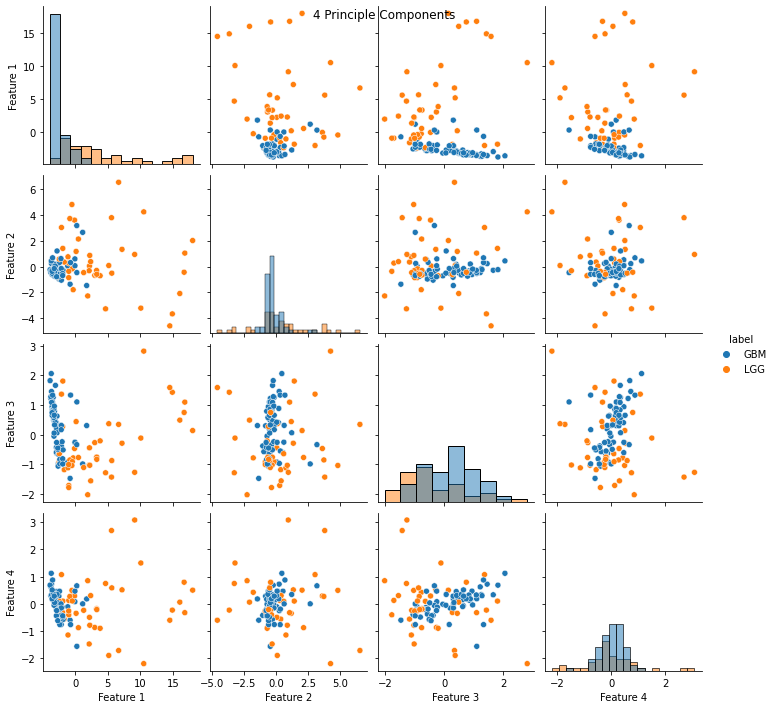

In [ ]:
# TM10007 Machine Learning - Main script

# Importing functions
from brats.load_data import load_data

# Importing modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold

import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Loading data
data = load_data()   # data is a dataframe 167x725 with first all GBM and then all LGG samples
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Data splitting in data and label
X = data.drop(columns=['label'])
Y = data['label']

# Data splitting in train (67%) and test (33%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, stratify=Y, random_state=0)

# Data cleaning
X_train_clean = clean_data(X_train, X_train)
X_test_clean = clean_data(X_train, X_test)

# Scaling the data
X_scaled_train = scale_data(X_train_clean, X_train_clean)
X_scaled_test = scale_data(X_train_clean, X_test_clean)

# Imputation of remaining missing values
X_imp_train = imputation(X_scaled_train, X_scaled_train)
X_imp_test = imputation(X_scaled_train, X_scaled_test)

# Plotting 4 principle components
X_select = feature_selection(X_imp_train, X_imp_train, X_train_clean, X_train_clean, Y_train, 40)
X_pca = feature_extraction(X_select, X_select, 4)
X_pca = pd.DataFrame(X_pca, columns=['Feature 1','Feature 2', 'Feature 3', 'Feature 4'])
X_pca['label'] = Y_train.tolist()
g = sns.pairplot(X_pca, hue='label', diag_kind="hist")
g.fig.suptitle("4 Principle Components")

## Looping over different methods

In [ ]:
plot_acc = []
plot_range = []
plot_acc_knn = []
plot_acc_linSVC = []
plot_acc_svmlin = []
plot_acc_svmpoly = []
plot_acc_svmrbf = []
plot_range_knn = []
plot_range_linSVC = []
plot_range_svmlin = []
plot_range_svmpoly = []
plot_range_svmrbf = []
best_clf = []

# Feature selection, extraction and classifier methods
threshs = [5, 10, 15, 20]
for i in threshs:
    print(f'Threshold for f-value is {i}')
    X_select_opt = feature_selection(X_imp_train, X_imp_train, X_train_clean, X_train_clean, Y_train, i)
    
    # Feature extraction
    comp = [20, 40, 60, 80]
    for j in comp:
        print(f'PCA extraction with {j} features')
        X_pca_opt = feature_extraction(X_select_opt, X_select_opt, j)
        
        # Construct classifiers
        linSVC = LinearSVC(random_state=0, tol=1e-5, dual=False)
        svmlin = SVC(kernel='linear', gamma='scale')
        svmpoly = SVC(kernel='poly', degree=3, gamma='scale')
        svmrbf = SVC(kernel='rbf', gamma='scale')

        clsfs = [KNeighborsClassifier(), linSVC, svmlin, svmpoly, svmrbf]
        scores = []
        
        # Specify cross-validation method (5 folds)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

        # Finding best performing classifier using cross-validation (5 folds)
        for clf in clsfs:
            clf.fit(X_pca_opt, Y_train)
            scores_train = cross_val_score(clf, X_pca_opt, Y_train, cv=cv)
            mean_train = np.mean(scores_train)
            plot_acc.append(mean_train)
            scores.append(mean_train)
            
            if clf == linSVC:
              plot_acc_linSVC.append(mean_train)
            
            elif clf == svmlin:
              plot_acc_svmlin.append(mean_train)
            
            elif clf == svmpoly:
              plot_acc_svmpoly.append(mean_train)
          
            elif clf == svmrbf:
              plot_acc_svmrbf.append(mean_train)
            
            else: 
              plot_acc_knn.append(mean_train)


        best_score = max(scores)
        index = scores.index(best_score)
        print(f'Best performing classifier: {clsfs[index]} with accuracy: {best_score}')

        best_clf.append(clsfs[index])


Threshold for f-value is 5
PCA extraction with 20 features
Best performing classifier: SVC(kernel='linear') with accuracy: 0.882608695652174
PCA extraction with 40 features
Best performing classifier: SVC() with accuracy: 0.8561264822134387
PCA extraction with 60 features
Best performing classifier: KNeighborsClassifier() with accuracy: 0.8553359683794467
PCA extraction with 80 features
Best performing classifier: LinearSVC(dual=False, random_state=0, tol=1e-05) with accuracy: 0.8735177865612649
Threshold for f-value is 10
PCA extraction with 20 features
Best performing classifier: SVC(kernel='linear') with accuracy: 0.891699604743083
PCA extraction with 40 features
Best performing classifier: KNeighborsClassifier() with accuracy: 0.8557312252964427
PCA extraction with 60 features
Best performing classifier: KNeighborsClassifier() with accuracy: 0.8648221343873518
PCA extraction with 80 features
Best performing classifier: KNeighborsClassifier() with accuracy: 0.8648221343873518
Thresh

## Searching for optimal method

[0.8739130434782609, 0.8466403162055336, 0.8553359683794467, 0.8553359683794467, 0.8648221343873518, 0.8557312252964427, 0.8648221343873518, 0.8648221343873518, 0.8557312252964427, 0.8466403162055336, 0.8466403162055336, 0.8375494071146246, 0.8648221343873518, 0.8470355731225296, 0.8470355731225296, 0.8470355731225296]
[0.8375494071146244, 0.7830039525691699, 0.8280632411067194, 0.8735177865612649, 0.8466403162055336, 0.8102766798418972, 0.8102766798418972, 0.8102766798418972, 0.8371541501976283, 0.8015810276679842, 0.8375494071146246, 0.8284584980237154, 0.7920948616600791, 0.8288537549407116, 0.8644268774703556, 0.8644268774703556]
[0.882608695652174, 0.7920948616600791, 0.8280632411067194, 0.8553359683794467, 0.891699604743083, 0.8102766798418972, 0.783399209486166, 0.8015810276679842, 0.8288537549407116, 0.8288537549407116, 0.8284584980237154, 0.8288537549407116, 0.8102766798418972, 0.8462450592885375, 0.8470355731225296, 0.8466403162055336]
[0.7830039525691701, 0.7652173913043478,

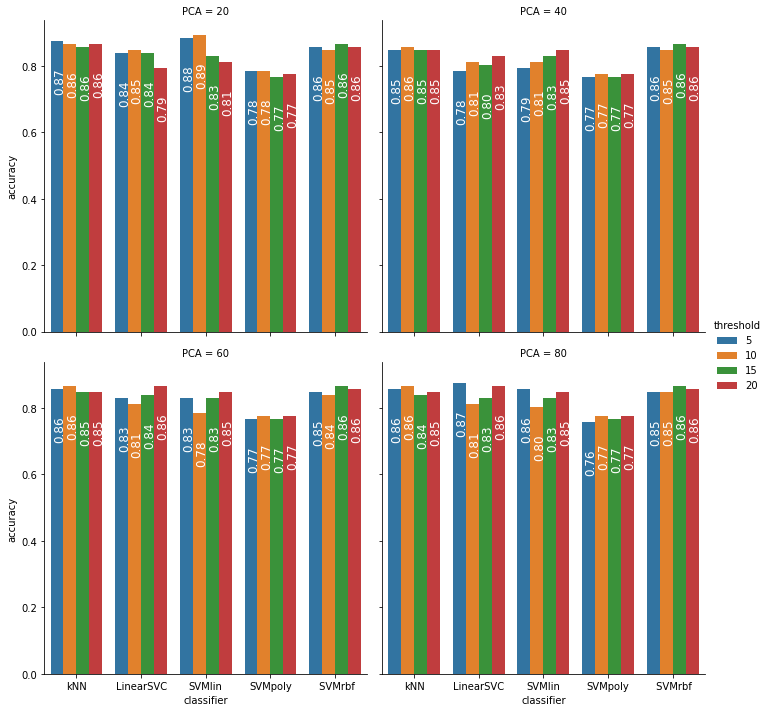

In [ ]:
dc = {'kNN': plot_acc_knn, 'LinearSVC': plot_acc_linSVC, 'SVMlin': plot_acc_svmlin, 'SVMpoly': plot_acc_svmpoly, ' SVMrbf': plot_acc_svmrbf}
df = pd.DataFrame(dc)

thresh = [5, 10, 15, 20]
components = [20, 40, 60, 80]

classifier = []
PCA_value = []
thresh_value = []
accuracy = []
for clsf in df:
    for index, value in enumerate(df[clsf]):
        classifier.append(clsf)
        PCA_value.append(components[index%4])
        thresh_value.append(thresh[index//4])
        accuracy.append(value)

result_dc = {'classifier': classifier, 'PCA': PCA_value, 'threshold': thresh_value, 'accuracy': accuracy}
result_df = pd.DataFrame(result_dc)

plot = sns.catplot(data = result_df,
                   x='classifier',
                   y='accuracy',
                   col='PCA',
                   hue='threshold',
                   kind='bar',
                   col_wrap=2,
                   ci="sd")

for i in np.arange(4):
    ax1 = plot.facet_axis(0,i)
    for p in ax1.patches:
        if str(p.get_height()) != 'nan':
            ax1.text(p.get_x()+0.04, p.get_height() - 0.15, '{0:.2f}'.format(p.get_height()), color='white', rotation='vertical', size='large')

print(plot_acc_knn)
print(plot_acc_linSVC)
print(plot_acc_svmlin)
print(plot_acc_svmpoly)
print(plot_acc_svmrbf)

print(np.mean(plot_range_knn))
print(np.mean(plot_range_svmrbf))

print(best_clf)

best_score_knn = max(plot_acc_knn)
print(best_score_knn)
index_knn = plot_acc_knn.index(best_score_knn)
print(index_knn)

best_score_linSVC = max(plot_acc_linSVC)
print(best_score_linSVC)
index_linSVC = plot_acc_linSVC.index(best_score_linSVC)
print(index_linSVC)

best_score_svmlin = max(plot_acc_svmlin)
print(best_score_svmlin)
index_svmlin = plot_acc_svmlin.index(best_score_svmlin)
print(index_svmlin)

best_score_svmpoly = max(plot_acc_svmpoly)
print(best_score_svmpoly)
index_svmpoly = plot_acc_svmpoly.index(best_score_svmpoly)
print(index_svmpoly)

best_score_svm = max(plot_acc_svmrbf)
print(best_score_svm)
index_svm = plot_acc_svmrbf.index(best_score_svm)
print(index_svm)


## SVM with RBF kernel Hyperparameter Optimalization

In [ ]:
# Feature selection
X_select_train_svm = feature_selection(X_imp_train, X_imp_train, X_train_clean, X_train_clean, Y_train, 10)

# Feature extraction
X_pca_train_svm = feature_extraction(X_select_train_svm, X_select_train_svm, 80)

scores_train = cross_val_score(svmrbf, X_pca_train_svm, Y_train, cv=cv)
print(scores_train)

# SVM classifier - hyperparameter optimization
# Defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

# Grid search using cross-validation (5 folds)
grid = GridSearchCV(SVC(kernel='rbf'), param_grid, refit=True, cv=cv, scoring='accuracy', return_train_score=True)

# Fit the grid to the training set
grid.fit(X_pca_train_svm, Y_train)
print(grid.cv_results_.keys())
print(grid.cv_results_["mean_train_score"] - grid.cv_results_["mean_test_score"])

# Print best parameters after tuning
print(f'Best parameters after tuning: {grid.best_params_}')

# Print how the model looks after hyper-parameter tuning
print(f'Selected classifier: {grid.best_estimator_}')

# Select the best performing classifer as the one to use
classifier_svm = grid.best_estimator_

# Apply classifier to the train data
train_results = classifier_svm.predict(X_pca_train_svm)
y_score = classifier_svm.decision_function(X_pca_train_svm)
train_acc = accuracy_score(Y_train, train_results)
print(f'Accuracy on train data: {train_acc}')

# Cross-validation scoring
scores_train = cross_val_score(classifier_svm, X_pca_train_svm, Y_train, cv=cv)
print(scores_train)
print('Cross-validation score: ', np.mean(scores_train))
print('Cross-validation score std: ', np.std(scores_train))


[0.82608696 0.81818182 0.81818182 0.86363636 0.90909091]
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_gamma', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])
[-3.33081672e-05 -3.33081672e-05  7.85673047e-02 -3.33081672e-05
 -3.33081672e-05  3.87351779e-01  3.87351779e-01  1.12489452e-01
  2.49122885e-02  4.74086246e-03  3.87351779e-01  3.69169960e-01
  1.62450593e-01  7.20266909e-02  1.35486521e-02  3.87351779e-01
  3.69169960e-01  1.44268775e-01  1.60598659e-01  6.97794999e-02
  3.87351779e-01  3.69169960e-01  1.44268775e-01  1.81027668e-01
  1.47013368e-01]
Best parameters after tuning: {'C': 10, 'gamma': 0.001}
Selected classifier: SVC(C=10, gamma=0.001)
Accurac

## k-Nearest Neighbor Classifier Hyperparameter Optimization

[0.86956522 0.86363636 0.90909091 0.86363636 0.86363636]
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])
[ 0.20750988  0.03376116  0.01804303  0.02253742  0.00897766  0.02274171
  0.02009926  0.02701959 -0.00477306  0.00434338  0.00434338  0.03161611
  0.01803082  0.01615335  0.01123818  0.02490008  0.02487454  0.03438624
  0.02030355  0.03208798  0.01840054  0.0253464   0.00943731  0.02769574
  0.02769574]
[0.7924901185770751, 0.8288537549407116, 0.8648221343873518, 0.8648221343873518, 0.8739130434782609, 0.8466403162055336, 0.8470355731225296, 0.8288537549407116, 0.8561264822134387, 0.8470355731225296, 0.84703557312

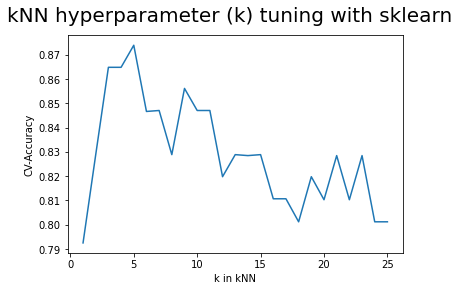

In [ ]:
# Feature selection with optimal method
X_select_train_knn = feature_selection(X_imp_train, X_imp_train, X_train_clean, X_train_clean, Y_train, 5)

# Feature extraction with optimal method
X_pca_train_knn = feature_extraction(X_select_train_knn, X_select_train_knn, 20)

knn = KNeighborsClassifier()
scores_train = cross_val_score(knn, X_pca_train_knn, Y_train, cv=cv)
print(scores_train)

# Create a grid search to find the optimal k using a gridsearch and 5-fold cross validation
k_values = np.arange(1,26)
param_grid = {"n_neighbors": k_values}
grid = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', return_train_score=True)
grid.fit(X_pca_train_knn, Y_train)
print(grid.cv_results_.keys())
print(grid.cv_results_["mean_train_score"] - grid.cv_results_["mean_test_score"])

# Compute accuracy for each k in k_values
accuracies = []
for k in k_values:
    # instantiate kNN with given neighbor size k
    knn = KNeighborsClassifier(n_neighbors=k)
    # run cross validation for a given kNN setup
    scores = cross_val_score(knn, X_pca_train_knn, Y_train, cv=cv, scoring='accuracy')
    accuracies.append(scores.mean())
print(accuracies)

# Plot accuracy for each k in k_values
fig = plt.figure()
plt.plot(k_values, accuracies)
plt.xlabel('k in kNN')
plt.ylabel('CV-Accuracy')
fig.suptitle('kNN hyperparameter (k) tuning with sklearn', fontsize=20)

# Print best parameters after tuning
print(f'Best parameters after tuning: {grid.best_params_}')

# Print how the model looks after hyper-parameter tuning
print(f'Selected classifier: {grid.best_estimator_}')

# Select the best performing classifer as the one to use
classifier_knn = grid.best_estimator_

# Apply classifier to the train data
train_results = classifier_knn.predict(X_pca_train_knn)
train_acc = accuracy_score(Y_train, train_results)
print(f'Accuracy on train data: {train_acc}')

# Cross-validation scoring
scores_train = cross_val_score(classifier_knn, X_pca_train_knn, Y_train, cv=cv)
print('Cross-validation score: ', np.mean(scores_train))
print('Cross-validation score std: ', np.std(scores_train))


## Applying kNN (k=5) to test data

Accuracy on test data: 0.8928571428571429
Accuracy: 0.8928571428571429
F1 score: 0.8904761904761905
Recall: 0.8928571428571429
Precision: 0.8982873851294905

 Clasification report:
               precision    recall  f1-score   support

         GBM       0.87      0.97      0.92        34
         LGG       0.94      0.77      0.85        22

    accuracy                           0.89        56
   macro avg       0.91      0.87      0.88        56
weighted avg       0.90      0.89      0.89        56

     LGG  GBM
LGG   33    1
GBM    5   17


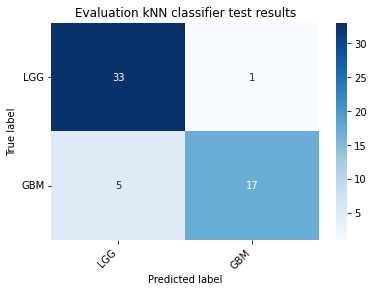

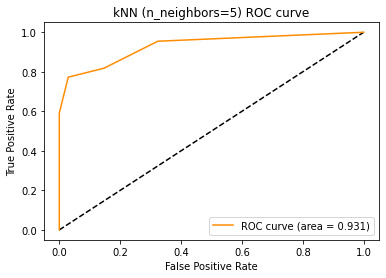

In [ ]:
# Apply feature selection and extraction to test data
X_select_test_knn = feature_selection(X_imp_train, X_imp_test, X_train_clean, X_test_clean, Y_train, 5)
X_pca_test_knn = feature_extraction(X_select_train_knn, X_select_test_knn, 20)

# Apply classifier to test data
test_results = classifier_knn.predict(X_pca_test_knn)
test_acc = accuracy_score(Y_test, test_results)
print(f'Accuracy on test data: {test_acc}')

# Printing results
print('Accuracy:', accuracy_score(Y_test, test_results))
print('F1 score:', f1_score(Y_test, test_results, average='weighted'))
print('Recall:', recall_score(Y_test, test_results,
                              average='weighted'))
print('Precision:', precision_score(Y_test, test_results,
                                    average='weighted'))
print('\n Clasification report:\n', classification_report(Y_test, test_results))

conmat = confusion_matrix(Y_test, test_results)
val = np.mat(conmat)
classnames = list(set(Y_train))
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames,
    )
print(df_cm)
# df_cm = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]

# Plotting confusion matrix
plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Evaluation kNN classifier test results')
plt.show()

# Plotting ROC curve
y_pred_proba = classifier_knn.predict_proba(X_pca_test_knn)[:,1]
auc = roc_auc_score(Y_test,y_pred_proba)

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba, pos_label='LGG')
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, color="darkorange", label=f"ROC curve (area = {auc:.3f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('kNN (n_neighbors=5) ROC curve')
plt.legend(loc="lower right")
plt.show()



## Applying SVM rbf to test data

Accuracy on test data: 0.875
Accuracy: 0.875
F1 score: 0.8730676743387153
Recall: 0.875
Precision: 0.8766002844950214

 Clasification report:
               precision    recall  f1-score   support

         GBM       0.86      0.94      0.90        34
         LGG       0.89      0.77      0.83        22

    accuracy                           0.88        56
   macro avg       0.88      0.86      0.87        56
weighted avg       0.88      0.88      0.87        56

     LGG  GBM
LGG   32    2
GBM    5   17


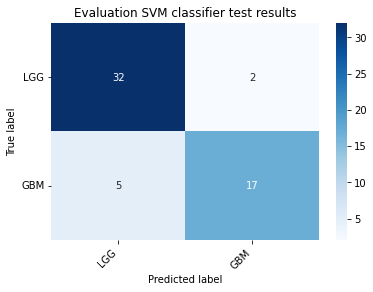

0.926470588235294


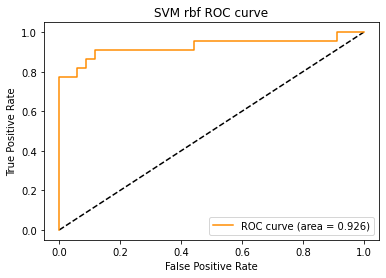

In [ ]:
# Apply feature selection and extraction to test data
X_select_test_svm = feature_selection(X_imp_train, X_imp_test, X_train_clean, X_test_clean, Y_train, 10)
X_pca_test_svm = feature_extraction(X_select_train_svm, X_select_test_svm, 80)

# Apply classifier to test data
test_results = classifier_svm.predict(X_pca_test_svm)
test_acc = accuracy_score(Y_test, test_results)
print(f'Accuracy on test data: {test_acc}')

# Printing results
print('Accuracy:', accuracy_score(Y_test, test_results))
print('F1 score:', f1_score(Y_test, test_results, average='weighted'))
print('Recall:', recall_score(Y_test, test_results,
                              average='weighted'))
print('Precision:', precision_score(Y_test, test_results,
                                    average='weighted'))
print('\n Clasification report:\n', classification_report(Y_test, test_results))

conmat = confusion_matrix(Y_test, test_results)
val = np.mat(conmat)
classnames = list(set(Y_train))
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames,
    )
print(df_cm)
# df_cm = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]

# Plotting confusion matrix
plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Evaluation SVM classifier test results')
plt.show()

# Plotting ROC curve
y_pred_proba = classifier_svm.decision_function(X_pca_test_svm)

auc = roc_auc_score(Y_test,y_pred_proba)

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba, pos_label='LGG')
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, color="darkorange", label=f"ROC curve (area = {auc:.3f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM rbf ROC curve')
plt.legend(loc="lower right")
plt.show()

